# How to pass graph state to tools

Sometimes we need to pass in agent state to our tools. This type of stateful tools is useful when a tool's output is affected by past agent steps (e.g. if you're using a sub-agent as a tool, and want to pass the message history in to the sub-agent), or when a tool's input needs to be validated given context from past agent steps. 

In this guide we'll demonstrate how to create tools that take agent state as input.

This is a special case of [passing runtime arguments to tools](https://python.langchain.com/v0.2/docs/how_to/tool_runtime/), which you can learn about in the LangChain docs.

## Setup

First we need to install the packages required

In [41]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain-openai

Next, we need to set API keys for OpenAI (the chat model we will use).

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Defining the tools

We'll want our tool to take graph state as an input, but we don't want the model to try to generate this input when calling the tool. We can use the `InjectedState` annotation to mark arguments as required graph state (or some field of graph state. These arguments will not be generated by the model. When using `ToolNode`, graph state will automatically be passed in to the relevant tools and arguments.

In this example we'll create a tool that returns Documents and then another tool that actually cites the Documents that justify a claim.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>  

In [2]:
from typing import List, Tuple
from typing_extensions import Annotated

from langchain_core.documents import Document
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState

from pydantic import BaseModel


@tool(parse_docstring=True, response_format="content_and_artifact")
def get_context(question: List[str]) -> Tuple[str, List[Document]]:
    """Get context on the question.

    Args:
        question: The user question
    """
    # return constant dummy output
    docs = [
        Document(
            "FooBar company just raised 1 Billion dollars!",
            metadata={"source": "twitter"},
        ),
        Document(
            "FooBar company is now only hiring AI's", metadata={"source": "twitter"}
        ),
        Document(
            "FooBar company was founded in 2019", metadata={"source": "wikipedia"}
        ),
        Document(
            "FooBar company makes friendly robots", metadata={"source": "wikipedia"}
        ),
    ]
    return "\n\n".join(doc.page_content for doc in docs), docs


@tool(parse_docstring=True, response_format="content_and_artifact")
def cite_context_sources(
    claim: str, state: Annotated[dict, InjectedState]
) -> Tuple[str, List[Document]]:
    """Cite which source a claim was based on.

    Args:
        claim: The claim that was made.
    """
    docs = []
    # We get the potentially cited docs from past ToolMessages in our state.
    for msg in state["messages"]:
        if isinstance(msg, ToolMessage) and msg.name == "get_context":
            docs.extend(msg.artifact)

    class Cite(BaseModel):
        """Return the index(es) of the documents that justify the claim"""

        indexes: List[int]

    structured_model = model.with_structured_output(Cite)
    system = f"Which of the following documents best justifies the claim:\n\n{claim}"
    context = "\n\n".join(
        f"Document {i}:\n" + doc.page_content for i, doc in enumerate(docs)
    )
    citation = structured_model.invoke([("system", system), ("human", context)])
    cited_docs = [docs[i] for i in citation.indexes]
    sources = ", ".join(doc.metadata["source"] for doc in cited_docs)
    return sources, cited_docs

If we look at the input schemas for these tools, we'll see that `state` is still listed:

In [3]:
cite_context_sources.get_input_schema().schema()

{'description': 'Cite which source a claim was based on.',
 'properties': {'claim': {'description': 'The claim that was made.',
   'title': 'Claim',
   'type': 'string'},
  'state': {'title': 'State', 'type': 'object'}},
 'required': ['claim', 'state'],
 'title': 'cite_context_sources',
 'type': 'object'}

But if we look at the tool call schema, which is what is passed to the model for tool-calling, `state` has been removed:

In [11]:
cite_context_sources.tool_call_schema.schema()

{'title': 'cite_context_sources',
 'description': 'Cite which source a claim was based on.',
 'type': 'object',
 'properties': {'claim': {'title': 'Claim',
   'description': 'The claim that was made.',
   'type': 'string'}},
 'required': ['claim']}

## Define the agent state

The main type of graph in `langgraph` is the `StateGraph`.
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [4]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [5]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode

model = ChatOpenAI(model="gpt-4o", temperature=0)


# Define the function that determines whether to continue or not
def should_continue(state, config):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


tools = [get_context, cite_context_sources]


# Define the function that calls the model
def call_model(state, config):
    messages = state["messages"]
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

## Define the graph

We can now put it all together and define the graph!

In [6]:
from langgraph.graph import END, START, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

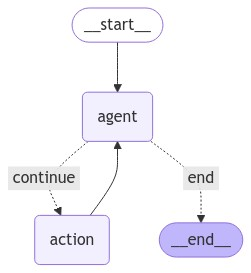

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [21]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage("what's the latest news about FooBar")]
for output in app.stream({"messages": messages}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
        messages.extend(value["messages"])
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BidVTw5NiW2wp8Ez7m8dDoHI', 'function': {'arguments': '{"question":["latest news about FooBar"]}', 'name': 'get_context'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 87, 'total_tokens': 106}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_c4e5b6fa31', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fcac1b73-563e-4f4c-b1b0-626f55d377be-0', tool_calls=[{'name': 'get_context', 'args': {'question': ['latest news about FooBar']}, 'id': 'call_BidVTw5NiW2wp8Ez7m8dDoHI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 19, 'total_tokens': 106})]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content="FooBar company just raised 1 Billion dollars!\n\nFooBar company is now only hiring AI's\n\nFooBar company was founded in 2019\n\nFooBar company makes friendly robo

In [22]:
messages.append(HumanMessage("where did you get this information?"))
for output in app.stream({"messages": messages}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EB0zaQypXMqEUzaqwflUr0zH', 'function': {'arguments': '{"claim":"FooBar company just raised 1 Billion dollars!"}', 'name': 'cite_context_sources'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 183, 'total_tokens': 208}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_c4e5b6fa31', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b4952777-e2b3-4448-be87-200e6e80981b-0', tool_calls=[{'name': 'cite_context_sources', 'args': {'claim': 'FooBar company just raised 1 Billion dollars!'}, 'id': 'call_EB0zaQypXMqEUzaqwflUr0zH', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 25, 'total_tokens': 208})]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='twitter', name='cite_context_sources', tool_call_id='call_EB0zaQypXMqEUzaqwflUr0zH', artifact=[Document(metadat